# Importing libraries

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
from numba import njit, jit
import os
import statistics

# Functions

In [ ]:
@njit
def burning_method(lattice):
    L = len(lattice)
    lattice[0] = np.where(lattice[0] == 1, lattice[0] + 1, lattice[0])
    end = False

    while not end:
        end = True
        for x in range(L):
            for y in range(L):
                if lattice[x][y] == 0:
                    continue

                neighbors = [
                    (x + 1, y),
                    (x, y + 1),
                    (x, y - 1),
                    (x - 1, y)
                ]

                for nx, ny in neighbors:
                    if 0 <= nx < L and 0 <= ny < L and lattice[nx][ny] == 1:
                        lattice[nx][ny] += lattice[x][y]
                        end = False

    return end, lattice

In [ ]:
def HK(lattice):
    L = len(lattice)
    counter = 2
    for i in range(L):
        for j in range(L):
            if lattice[i, j] == 1:
                left_neighbor = lattice[i, j - 1] if j > 0 else 0
                above_neighbor = lattice[i - 1, j] if i > 0 else 0

                neighbors = [left_neighbor, above_neighbor]

                if any(neighbors):
                    min_neighbor = min(neighbors)
                    lattice[i, j] = min_neighbor

                    for x, y in np.argwhere(lattice == max(neighbors)):
                        lattice[x, y] = min_neighbor
                else:
                    lattice[i, j] = counter
                    counter += 1

    return lattice

In [ ]:
def p_critical_to_file(P, p_flow, avg_cluster_sizes, L, T):
    with open("output_data\Ave_L"+str(L)+"T"+str(T)+".txt", 'w') as f:
        for p, p_f, avg in zip(P, p_flow, avg_cluster_sizes):
            f.write(str(p)+"  "+str(p_f)+"  "+str(avg)+"\n")
        f.close()

def dist_of_clusters_to_file(nspL, p, L, T):
    output_dir = "output_data"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print(str(format(round(p, 3), '.2f')))
    with open(f"{output_dir}/Dist_p{format(round(p, 3), '.2f')}L{L}T{T}.txt", 'w') as f:
        for s, n in zip(nspL.keys(), nspL.values()):
            f.write(str(s) + "  " + str(float(n)) + "\n")
        f.close()

In [ ]:
@njit
def find_max_cluster(lattice):
    clusters_sizes = []
    max_size = 0
    min_cluster_size = 2
    max_cluster_size = np.max(lattice)

    for size in range(min_cluster_size, max_cluster_size + 1):
        indices = np.argwhere(lattice == size)
        cluster_size = len(indices)

        if cluster_size != 0:
            clusters_sizes.append(size)

            if cluster_size > max_size:
                max_size = cluster_size

    return max_size, clusters_sizes


def find_cluster_sizes(clusters, clusters_array):
    cluster_sizes = []

    for c in clusters_array:
        cluster_indices = np.argwhere(clusters == c)
        cluster_sizes.append(len(cluster_indices))

    return cluster_sizes


def distribution(L, T, p0, dp, pk):
    L = L
    number_of_steps = int((pk-p0)/dp)+1
    P = np.linspace(p0, pk, number_of_steps)
    P = np.append(P, np.array([0.592746]))
    P = np.sort(P)
    T = T
    probability = []
    for p in P:
        print(p)
        dist = dict()
        for t in range(T):
            lattice = np.random.choice(2, [L, L], p=[1 - p, p])
            clusters = HK(lattice)
            max_size, array_of_clusters = find_max_cluster(clusters)
            nspL = dict()
            if len(array_of_clusters) != 0:
                array_of_clusters_sizes = find_cluster_sizes(clusters, array_of_clusters)
                for s in array_of_clusters_sizes:
                    if s in nspL.keys():
                        nspL[s] += (1/len(array_of_clusters_sizes))
                    else:
                        nspL[s] = (1/len(array_of_clusters_sizes))
                for k in nspL.keys():
                    if k in dist.keys():
                        dist[k] += nspL[k]/T
                    else:
                        dist[k] = nspL[k] / T
        dist_of_clusters_to_file(dist, p, L, T)
    return P, probability


def p_critical(L, T, p0, dp, pk):
    L = L
    number_of_steps = int((pk-p0)/dp)+1
    P = np.linspace(p0, pk, number_of_steps)
    P = np.append(P, np.array([0.592746]))
    T = T
    probability = []
    avg_cluster_sizes = []
    for p in P:
        print(p)
        is_ended = []
        max_cluster_sizes = []
        for t in range(T):
            lattice = np.random.choice(2, [L, L], p=[1 - p, p])
            lattice[0] = np.where(lattice[0] == 1, lattice[0] + 1, lattice[0])
            end, perc_lattice = burning_method(lattice)
            clusters = HK(lattice)
            max_size, array_of_clusters = find_max_cluster(clusters)
            is_ended.append(end)
            max_cluster_sizes.append(max_size)
        probability.append(is_ended.count(True))
        avg_cluster_sizes.append(statistics.fmean(max_cluster_sizes))
    probability = list(np.array(probability)/T)
    p_critical_to_file(P, probability, avg_cluster_sizes, L, T)
    return P, probability

# The Burning Method - visualization

In [ ]:
def initialize_lattice(L, p):
    lattice = (np.random.rand(L, L) < p).astype(int) #lattice = np.random.choice([0, 1], size=(L, L), p=[1 - p, p])
    return lattice


def visualize_lattice(lattice):
    plt.imshow(lattice, cmap='binary',interpolation = 'nearest')
    plt.show()

def color_code_heatmap(matrix):
    matrix = np.array(matrix)
    zero_mask = matrix == 0

    colors = [(0.8, 0.8, 0.8), (0.1, 0.1, 0.1)]

    cmap = LinearSegmentedColormap.from_list('custom_grey', colors)
    plt.imshow(np.ma.masked_array(matrix, zero_mask), cmap=cmap, interpolation='nearest')

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, str(matrix[i, j]), ha='center', va='center', color='black')

    plt.title('The Burning Methood for L = 10, p = 0.8')
    plt.xticks([])
    plt.yticks([])
    plt.show()

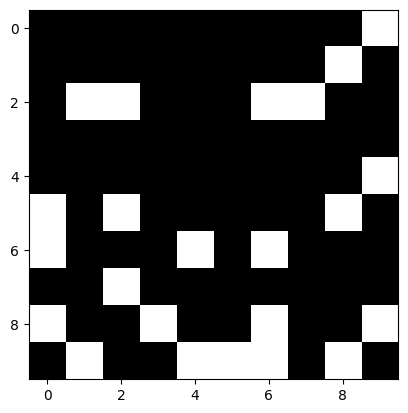

None


In [ ]:
L = 10
p = 0.8 #0.6 0.4 -> Each visualization done separately

random_lattice = initialize_lattice(L, p)
print(visualize_lattice(random_lattice))
copy_lattice = random_lattice.copy()

In [ ]:
end_second, lattice_b = burning_method(random_lattice)

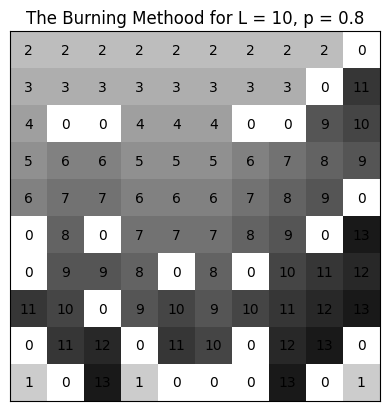

None


In [ ]:
# Exemplary usage
print(color_code_heatmap(lattice_b))

# Hoshen-Kopelman - visualization

In [ ]:
def visualize_hk(result_lattice):
    unique_labels = np.unique(result_lattice)
    cmap = plt.get_cmap('tab20', len(unique_labels))
    cmap.set_under('white')  # set 0 sites to white

    plt.imshow(result_lattice, cmap=cmap, interpolation='nearest', vmin=0.5)
    plt.title("The HK Algorithm for L = 10, p = 0.8")
    plt.colorbar(ticks=unique_labels, label='Cluster Labels')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
lattice_HK = HK(copy_lattice)

In [ ]:
print(lattice_HK)

[[ 2  0  2  2  2  0  0  4  4  4]
 [ 2  2  2  2  2  2  0  0  0  0]
 [ 2  0  2  2  0  2  2  2  0  5]
 [ 0  0  2  0  6  0  0  2  2  0]
 [ 0  0  0  0  6  0  7  0  0  0]
 [ 8  0  6  6  6  6  0  0  0  0]
 [ 0  0  0  0  6  0  0 10  0 11]
 [12 12 12  0  6  6  6  0  0  0]
 [ 0 12  0  0  0  6  6  0 13  0]
 [12 12  0 15 15  0  6  0 13  0]]


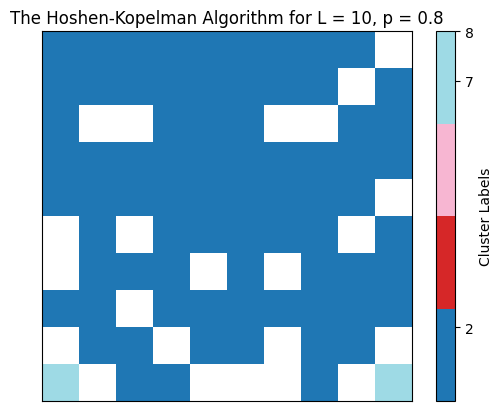

In [ ]:
visualize_hk(lattice_HK)

# Execution of functions

In [ ]:
file_path = "perc_ini.txt"

with open(file_path, 'r') as file:
    data_from_file = {line.split('%')[1].strip(): line.split('%')[0].strip() for line in file}

print(data_from_file)

# extracting parameters
L = int(data_from_file['L'])
T = int(data_from_file['T'])
p0 = float(data_from_file['p0'])
pk = float(data_from_file['pk'])
dp = float(data_from_file['dp'])
number_of_steps = int((pk - p0) / dp) + 1
P = np.linspace(p0, pk, number_of_steps)

# distribution(L=L, T=T, p0=p0, pk=pk, dp=dp)
p_critical(L=L, T=T, p0=p0, pk=pk, dp=dp)

{'L': '10', 'T': '1000', 'p0': '0.01', 'pk': '1', 'dp': '0.01'}
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.9600000000000001
0.97
0.98
0.99
1.0
0.592746


(array([0.01    , 0.02    , 0.03    , 0.04    , 0.05    , 0.06    ,
        0.07    , 0.08    , 0.09    , 0.1     , 0.11    , 0.12    ,
        0.13    , 0.14    , 0.15    , 0.16    , 0.17    , 0.18    ,
        0.19    , 0.2     , 0.21    , 0.22    , 0.23    , 0.24    ,
        0.25    , 0.26    , 0.27    , 0.28    , 0.29    , 0.3     ,
        0.31    , 0.32    , 0.33    , 0.34    , 0.35    , 0.36    ,
        0.37    , 0.38    , 0.39    , 0.4     , 0.41    , 0.42    ,
        0.43    , 0.44    , 0.45    , 0.46    , 0.47    , 0.48    ,
        0.49    , 0.5     , 0.51    , 0.52    , 0.53    , 0.54    ,
        0.55    , 0.56    , 0.57    , 0.58    , 0.59    , 0.6     ,
        0.61    , 0.62    , 0.63    , 0.64    , 0.65    , 0.66    ,
        0.67    , 0.68    , 0.69    , 0.7     , 0.71    , 0.72    ,
        0.73    , 0.74    , 0.75    , 0.76    , 0.77    , 0.78    ,
        0.79    , 0.8     , 0.81    , 0.82    , 0.83    , 0.84    ,
        0.85    , 0.86    , 0.87    , 0.88    , 

# Plotting results

**Probability p_flow that the path connecting the first and the last row exists as a function of p for L = 10, 50, 100 with legend.**

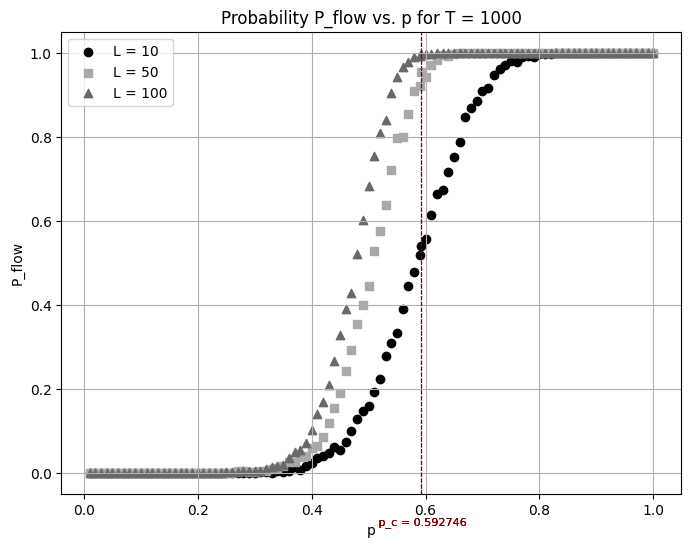

In [ ]:
def read_pflow(file_path):
    p_values = []
    P_flow_values = []
    with open(file_path, 'r') as file:
        for line in file:
            p, P_flow, _ = map(float, line.split())
            p_values.append(p)
            P_flow_values.append(P_flow)
    return p_values, P_flow_values

file_paths = ['Ave_L10T1000.txt', 'Ave_L50T1000.txt', 'Ave_L100T1000.txt']
L_values = [10, 50, 100]
markers = ['o', 's', '^']

plt.figure(figsize=(8, 6))


for i, file_path in enumerate(file_paths):
    p_values, P_flow_values = read_pflow(file_path)
    L = L_values[i]
    marker = markers[i]
    colors = ['black', 'darkgrey', 'dimgray']
    plt.scatter(p_values, P_flow_values, label=f'L = {L}', marker=marker, color=colors[i])

# for i in range(len(file_paths)):
#     plt.axvline(x=0.592746, linestyle='--', color='darkred', linewidth=0.8)
p_c = 0.592746
for i in range(len(file_paths)):
    plt.axvline(x=p_c, linestyle='--', color='darkred', linewidth=0.8)
    plt.text(p_c, plt.ylim()[0] - 0.055, f' p_c = {p_c}', ha='center', va='top', color='darkred', fontsize=8)



plt.xlabel('p')
plt.ylabel('P_flow')
plt.title('Probability P_flow vs. p for T = 1000')
plt.legend()
plt.grid(True)
plt.show()

**The average size of the maximum cluster ⟨s max⟩ as a function of p for L = 10,50,100 with legend.**

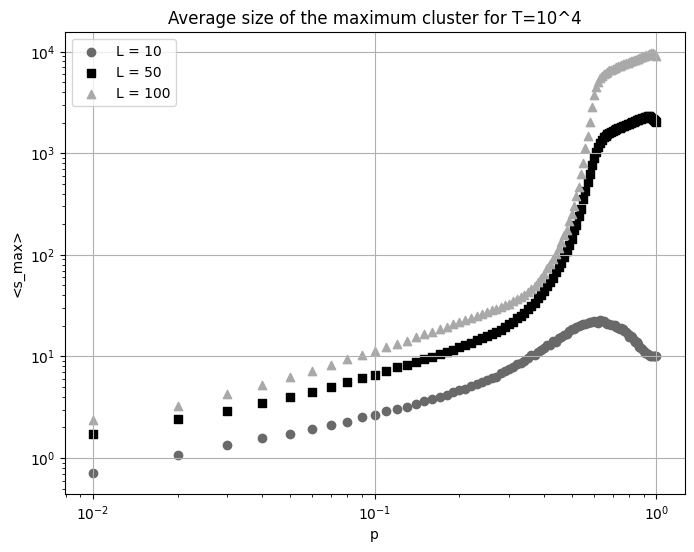

In [ ]:
def read_smax(file_path):
    p_values = []
    s_max_values = []
    with open(file_path, 'r') as file:
        lines = file.readlines()[:-1]
        for line in lines:
            p, _, s_max = map(float, line.split())
            p_values.append(p)
            s_max_values.append(s_max)
    return p_values, s_max_values

file_paths = ['Ave_L10T1000.txt', 'Ave_L50T1000.txt', 'Ave_L100T1000.txt']
L_values = [10, 50, 100]

plt.figure(figsize=(8, 6))

for i, file_path in enumerate(file_paths):
    p_values, s_max_values = read_smax(file_path)
    L = L_values[i]
    marker = markers[i]
    colors = ['dimgray','black', 'darkgrey']
    plt.scatter(p_values, s_max_values, label=f'L = {L}', marker=marker, color=colors[i])

plt.xlabel('p')
plt.ylabel('<s_max>')
plt.title('Average size of the maximum cluster for T=10^4')
plt.legend()

# plt.yticks([0,10,100,1000,10000])
# plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

**Distribution of clusters n(s,p,L) for a given p = 0.2,0.3,0.4,0.5,pc = 0.592746,0.6,0.7,0.8 with legend.**

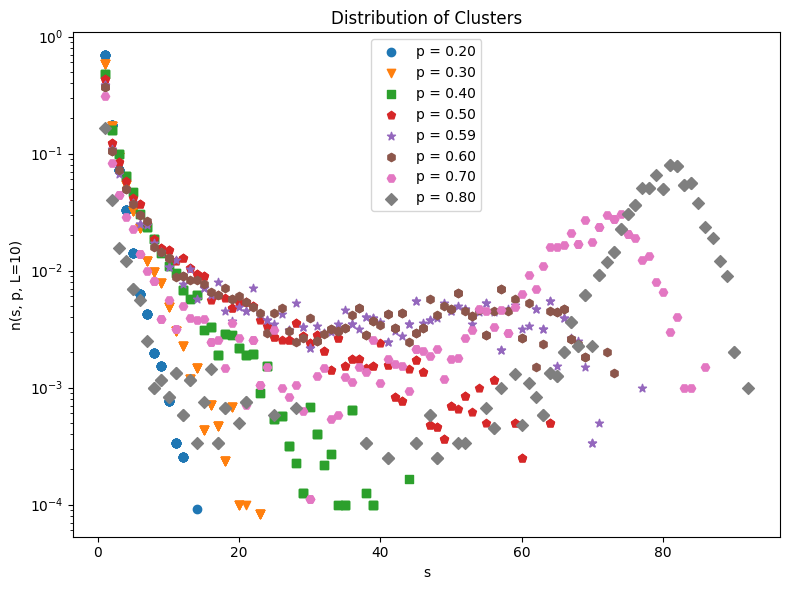

In [ ]:
file_paths = ['Dist_p0.20L10T1000.txt', 'Dist_p0.30L10T1000.txt','Dist_p0.40L10T1000.txt','Dist_p0.50L10T1000.txt',
              'Dist_p0.59L10T1000.txt', 'Dist_p0.60L10T1000.txt', 'Dist_p0.70L10T1000.txt', 'Dist_p0.80L10T1000.txt']

def read_data(file_path):
    data = np.loadtxt(file_path)
    return data[:, 0], data[:, 1]

def subsample_data(s, n_s, n_samples):
    idx = np.linspace(0, len(s) - 1, n_samples).astype(int)
    return s[idx], n_s[idx]

plt.figure(figsize=(8, 6))
markers = ['o', 'v', 's', 'p', '*', 'h', 'H', 'D', 'd']

for i, file_path in enumerate(file_paths):
    s, n_s = read_data(file_path)
    s, n_s = subsample_data(s, n_s, 100)

    p_value = float(file_path.split('p')[1].split('L')[0])
    plt.scatter(s, n_s, marker=markers[i], label=f'p = {p_value:.2f}')

plt.xlabel('s')
plt.ylabel('n(s, p, L=10)')
plt.title('Distribution of Clusters')
plt.legend()
plt.yscale('log')
plt.xscale('linear')
plt.tight_layout()
plt.show()

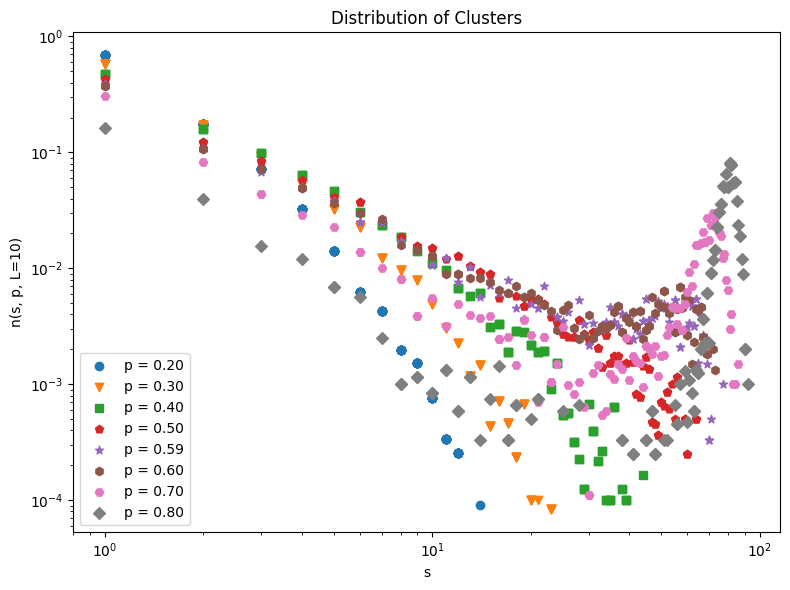

In [ ]:
file_paths = ['Dist_p0.20L10T1000.txt', 'Dist_p0.30L10T1000.txt','Dist_p0.40L10T1000.txt','Dist_p0.50L10T1000.txt',
              'Dist_p0.59L10T1000.txt', 'Dist_p0.60L10T1000.txt', 'Dist_p0.70L10T1000.txt', 'Dist_p0.80L10T1000.txt']

def read_data(file_path):
    data = np.loadtxt(file_path)
    return data[:, 0], data[:, 1]

def subsample_data(s, n_s, n_samples):
    idx = np.linspace(0, len(s) - 1, n_samples).astype(int)
    return s[idx], n_s[idx]

plt.figure(figsize=(8, 6))
markers = ['o', 'v', 's', 'p', '*', 'h', 'H', 'D', 'd']

for i, file_path in enumerate(file_paths):
    s, n_s = read_data(file_path)
    s, n_s = subsample_data(s, n_s, 100)

    p_value = float(file_path.split('p')[1].split('L')[0])
    plt.scatter(s, n_s, marker=markers[i], label=f'p = {p_value:.2f}')

plt.xlabel('s')
plt.ylabel('n(s, p, L=10)')
plt.title('Distribution of Clusters')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.show()

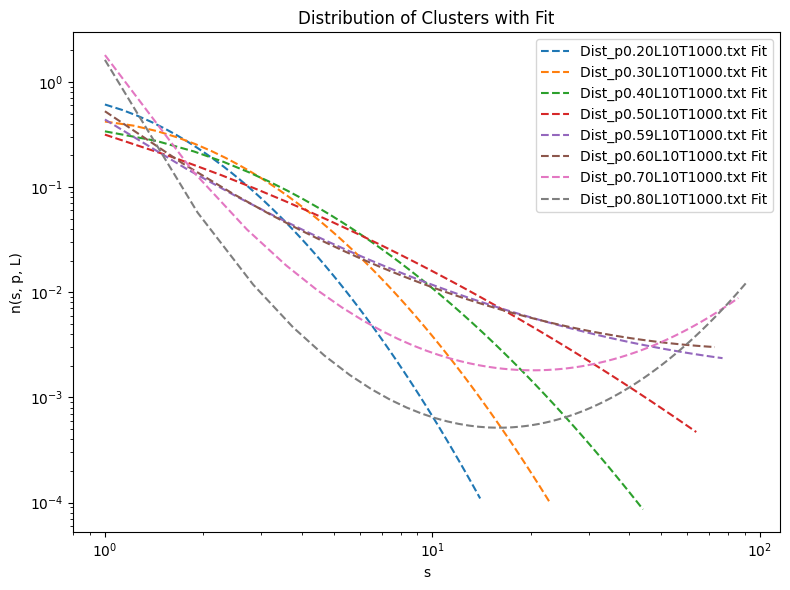

In [ ]:
file_paths = ['Dist_p0.20L10T1000.txt', 'Dist_p0.30L10T1000.txt','Dist_p0.40L10T1000.txt','Dist_p0.50L10T1000.txt',
              'Dist_p0.59L10T1000.txt', 'Dist_p0.60L10T1000.txt', 'Dist_p0.70L10T1000.txt', 'Dist_p0.80L10T1000.txt']

def read_data(file_path):
    data = np.loadtxt(file_path)
    return data[:, 0], data[:, 1]

plt.figure(figsize=(8, 6))
markers = ['o', 'v', 's', 'p', '*', 'h', 'H', 'D', 'd']

for i, file_path in enumerate(file_paths):
    s, n_s = read_data(file_path)

    coeffs = np.polyfit(np.log10(s), np.log10(n_s), 2)
    s_fit = np.linspace(min(s), max(s), 100)
    n_s_fit = 10**(np.polyval(coeffs, np.log10(s_fit)))

    plt.plot(s_fit, n_s_fit, label=f'{file_path} Fit', linestyle='--')

plt.xlabel('s')
plt.ylabel('n(s, p, L)')
plt.title('Distribution of Clusters with Fit')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.show()

**Distribution of clusters n(s,p,L) for a given p = 0.2,0.3,0.4,0.5,pc = 0.592746,0.6,0.7,0.8  with 3 subplots: for p < pc, p = pc and p > pc.**

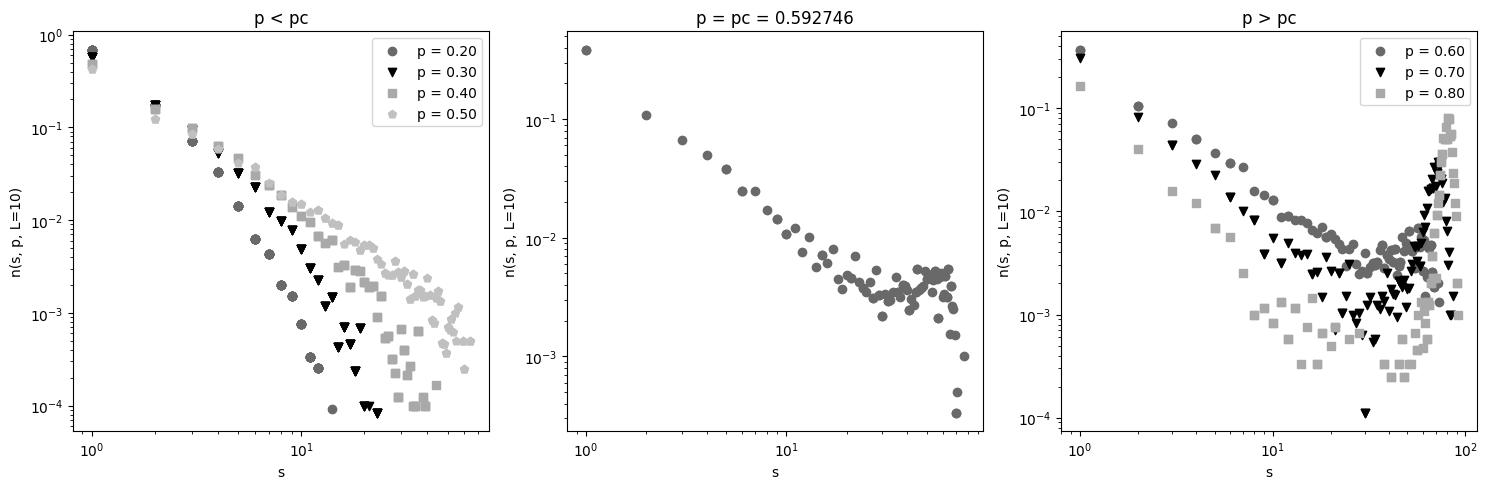

In [ ]:
file_1 = ['Dist_p0.20L10T1000.txt', 'Dist_p0.30L10T1000.txt', 'Dist_p0.40L10T1000.txt', 'Dist_p0.50L10T1000.txt']
file_pc = ['Dist_p0.59L10T1000.txt']
file_3 = ['Dist_p0.60L10T1000.txt', 'Dist_p0.70L10T1000.txt', 'Dist_p0.80L10T1000.txt']

def read_data(file_path):
    data = np.loadtxt(file_path)
    return data[:, 0], data[:, 1]

def subsample_data(s, n_s, n_samples):
    idx = np.linspace(0, len(s) - 1, n_samples).astype(int)
    return s[idx], n_s[idx]

plt.figure(figsize=(15, 5))
markers = ['o', 'v', 's', 'p', '*', 'h', 'H', 'D', 'd']

# p < pc
plt.subplot(1, 3, 1)
# plt.figure(figsize=(8, 6))
for i, file_path in enumerate(file_1):
    s, n_s = read_data(file_path)
    s, n_s = subsample_data(s, n_s, 100)
    p_value = float(file_path.split('p')[1].split('L')[0])
    plt.scatter(s, n_s, marker=markers[i], label=f'p = {p_value:.2f}', color=['dimgray', 'black', 'darkgrey', 'silver'][i])

plt.xlabel('s')
plt.ylabel('n(s, p, L=10)')
plt.title('p < pc')
plt.legend()
plt.yscale('log')
plt.xscale('log')

# p = pc
plt.subplot(1, 3, 2)
# plt.figure(figsize=(8, 6))
for i, file_path in enumerate(file_pc):
    s, n_s = read_data(file_path)
    s, n_s = subsample_data(s, n_s, 100)
    p_value = float(file_path.split('p')[1].split('L')[0])
    plt.scatter(s, n_s, marker=markers[i], label=f'p = {p_value:.2f}', color=['dimgray', 'black', 'darkgrey', 'silver'][i])

plt.xlabel('s')
plt.ylabel('n(s, p, L=10)')
plt.title('p = pc = 0.592746')
plt.yscale('log')
plt.xscale('log')

# p > pc
plt.subplot(1, 3, 3)
# plt.figure(figsize=(8, 6))
for i, file_path in enumerate(file_3):
    s, n_s = read_data(file_path)
    s, n_s = subsample_data(s, n_s, 100)
    p_value = float(file_path.split('p')[1].split('L')[0])
    plt.scatter(s, n_s, marker=markers[i], label=f'p = {p_value:.2f}', color=['dimgray', 'black', 'darkgrey', 'silver'][i])

plt.xlabel('s')
plt.ylabel('n(s, p, L=10)')
plt.title('p > pc')
plt.legend()
plt.yscale('log')
plt.xscale('log')

plt.tight_layout()
plt.show()